# Electric Scooter Rental Analysis
This notebook explores electric scooter rental data and builds a predictive model for hourly utilization.

##  Data Loading and Exploration
We'll start by loading the scooter rental data and performing initial exploratory analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from time import time
import joblib


# Set display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [2]:
# Load the data
data = pd.read_csv(r"C:\Users\PC\Downloads\scooter.csv")

In [3]:
# Checking the data types and non-null counts for each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17144 entries, 0 to 17143
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  17144 non-null  int64  
 1   date        17144 non-null  object 
 2   hour        17144 non-null  int64  
 3   holiday     17144 non-null  int64  
 4   weather     16874 non-null  float64
 5   temp        16864 non-null  float64
 6   temp_felt   16859 non-null  float64
 7   humidity    16866 non-null  float64
 8   windspeed   16873 non-null  float64
 9   co          16953 non-null  object 
 10  type_a      15343 non-null  float64
 11  type_b      16759 non-null  float64
 12  type_ab     16781 non-null  float64
dtypes: float64(8), int64(3), object(2)
memory usage: 1.7+ MB


To make the processing easier, let's convert the data types of some columns to the appropriate types.

In [4]:
# Convert 'co' column to numeric, replacing commas with dots
data['co'] = data['co'].str.replace(',', '.', regex=False)
data['co'] = pd.to_numeric(data['co'], errors='coerce')

In [5]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data.head()

,Unnamed: 0,date,hour,holiday,weather,temp,temp_felt,humidity,windspeed,co,type_a,type_b,type_ab
0,0,2016-01-06,19,0,1.0,276.43,274.1516,0.38,7.0015,2.9,5.0,127.0,132.0
1,1,2016-01-06,20,0,1.0,275.49,272.1518,0.47,11.0014,2.9,7.0,82.0,89.0
2,2,2016-01-06,21,0,1.0,274.55,270.1520,0.51,12.9980,2.9,3.0,40.0,43.0
3,3,2016-01-06,22,0,1.0,273.61,270.1520,0.55,8.9981,2.9,1.0,41.0,42.0
4,4,2016-01-06,23,0,1.0,274.55,274.1516,0.47,0.0000,2.9,1.0,18.0,19.0


In [ ]:
# Descriptive statistics
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Unnamed: 0,17144.0,8571.5,0.0,4285.75,8571.5,12857.25,17143.0,4949.190843
date,17144,2017-01-01 20:56:38.413439232,2016-01-06 00:00:00,2016-07-07 00:00:00,2017-01-02 00:00:00,2017-06-30 00:00:00,2017-12-27 00:00:00,NaN
hour,17144.0,11.544972,0.0,6.0,12.0,18.0,23.0,6.914775
holiday,17144.0,0.029165,0.0,0.0,0.0,0.0,1.0,0.168273
weather,16874.0,1.425981,1.0,1.0,1.0,2.0,4.0,0.640596
temp,16864.0,40.982183,-7.06,10.8,18.32,25.84,296.17,76.122399
temp_felt,16859.0,41.064077,-14.9968,11.0006,18.9998,28.0022,298.1492,75.370473
humidity,16866.0,0.62908,0.0,0.48,0.63,0.79,1.0,0.193013
windspeed,16873.0,12.644174,0.0,7.0015,11.0014,16.9979,56.9969,8.144561
co,16953.0,-41.439061,-200.0,0.8,2.3,3.2,8.4,83.792597


In [8]:
# Checking for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

weather       270
temp          280
temp_felt     285
humidity      278
windspeed     271
co            191
type_a       1801
type_b        385
type_ab       363
dtype: int64


Since the week day, whether the day is weekend, month, or year shall be important features for the analysis, let's exctract them from the date

In [ ]:
date_dt = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['day'] = date_dt.dt.day
data['month'] = date_dt.dt.month
data['year'] = date_dt.dt.year
data['day_of_week'] = date_dt.dt.day_name()
data['is_weekend'] = (date_dt.dt.dayofweek >= 5).astype(int)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17144 entries, 0 to 17143
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   17144 non-null  int64         
 1   date         17144 non-null  datetime64[ns]
 2   hour         17144 non-null  int64         
 3   holiday      17144 non-null  int64         
 4   weather      16874 non-null  float64       
 5   temp         16864 non-null  float64       
 6   temp_felt    16859 non-null  float64       
 7   humidity     16866 non-null  float64       
 8   windspeed    16873 non-null  float64       
 9   co           16953 non-null  float64       
 10  type_a       15343 non-null  float64       
 11  type_b       16759 non-null  float64       
 12  type_ab      16781 non-null  float64       
 13  day          17144 non-null  int32         
 14  month        17144 non-null  int32         
 15  year         17144 non-null  int32         
 16  day_

To avoid the data leakage problem, let's split the data into training, validation and testing sets before any preprocessing

In [11]:
# Split the data temporal ordering (70% training, 15% Validation, 15% Testing)
# Sort the data chronologically first, to avoid temporal leakage
data_sorted = data.sort_values(by='date')

# Determine split points based on dates
n_samples = len(data_sorted)
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

# Split the data
train_data = data_sorted.iloc[:train_size]
val_data = data_sorted.iloc[train_size:train_size + val_size]
test_data = data_sorted.iloc[train_size + val_size:]

# Split features and target, 'type_ab' is only the target variable
X_train = train_data.drop(['type_ab'], axis=1)
y_train = train_data['type_ab']

X_val = val_data.drop(['type_ab'], axis=1)
y_val = val_data['type_ab']

X_test = test_data.drop(['type_ab'], axis=1)
y_test = test_data['type_ab']

# Check the sizes and date ranges of the resulting datasets
print(f"Total dataset size: {len(data)}")
print(f"Training set size: {len(X_train)} ({len(X_train)/len(data):.1%})")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(data):.1%})")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(data):.1%})")

Total dataset size: 17144
Training set size: 12000 (70.0%)
Validation set size: 2571 (15.0%)
Test set size: 2573 (15.0%)


The test set would be kept out and all preprocessing steps, analysis etc. would be done only on the training data

I will keep the type_a and type_b coulmns only in the training data to do some analysis across the two groups

In [ ]:
val_data = val_data.drop(['type_a', 'type_b'], axis=1)
test_data = test_data.drop(['type_a', 'type_b'], axis=1)

## Handling missing data

First, let's explore the missing data in the three sets

In [ ]:
def check_missing_values(dataset, dataset_name):
    missing_values = dataset.isnull().sum()
    missing_percent = (dataset.isnull().sum() / len(dataset)) * 100
    
    missing_data = pd.DataFrame({
        f'Missing Count in {dataset_name}': missing_values[missing_values > 0],
        f'Missing Percent in {dataset_name}': missing_percent[missing_values > 0].round(2)
    })
    
    print(f"\n--- Missing Values in {dataset_name} ---")
    print(missing_data)
    return missing_data

# Check missing values for each dataset
train_missing = check_missing_values(train_data, "Training Data")
val_missing = check_missing_values(val_data, "Validation Data")
test_missing = check_missing_values(test_data, "Test Data")


--- Missing Values in Training Data ---
           Missing Count in Training Data  Missing Percent in Training Data
weather                               246                              2.05
temp                                  255                              2.12
temp_felt                             259                              2.16
humidity                              248                              2.07
windspeed                             248                              2.07
co                                    191                              1.59
type_a                               1501                             12.51
type_b                                384                              3.20
type_ab                               363                              3.02

--- Missing Values in Validation Data ---
           Missing Count in Validation Data  \
weather                                   8   
temp                                     12   
temp_felt      

There is missing data in the three sets. Let's handle that in the training set and then in the validation and test sets

To beging with type_a, which has the most missing values. Since type_ab is the summation of type_a and type_b and the missing values in type_b and type_ab are significantlly less, we can fill many of type_a mssing values by just subtracting type_b from type_ab where both values are not NAN

In [ ]:
mask = train_data['type_a'].isna() & train_data['type_ab'].notna() & train_data['type_b'].notna()
train_data.loc[mask, 'type_a'] = train_data.loc[mask, 'type_ab'] - train_data.loc[mask, 'type_b']


print("\nMissing values after first step:")
print(train_data[['type_a', 'type_b', 'type_ab']].isna().sum())


Missing values after first step:
type_a     363
type_b     384
type_ab    363
dtype: int64


We can do the same with the missing values in type_b

In [ ]:
mask = train_data['type_b'].isna() & train_data['type_ab'].notna() & train_data['type_a'].notna()
train_data.loc[mask, 'type_b'] = train_data.loc[mask, 'type_ab'] - train_data.loc[mask, 'type_a']


print("\nMissing values after second step:")
print(train_data[['type_a', 'type_b', 'type_ab']].isna().sum())


Missing values after second step:
type_a     363
type_b     363
type_ab    363
dtype: int64


Since the data is time series, filling these missing values with a time interpolation makes more sense. The distribution of both type_a and type_b columns might be different so I prefer to interpolate the missing values for variable seperatly and then add the two columns to get type_ab

In [ ]:
# Sort by datetime to ensure proper interpolation
df_sorted = train_data.sort_values('date')

# Convert the 'date' column to datetime format
df_sorted['date'] = pd.to_datetime(df_sorted['date'])

# Now setting the date column as the index
df_sorted = df_sorted.set_index('date')

# Time interpolation for type_a
df_sorted['type_a'] = df_sorted['type_a'].interpolate(method='time')
df_sorted['type_a'] = df_sorted['type_a'].fillna(method='ffill').fillna(method='bfill')

# Time interpolation for type_b
df_sorted['type_b'] = df_sorted['type_b'].interpolate(method='time')
df_sorted['type_b'] = df_sorted['type_b'].fillna(method='ffill').fillna(method='bfill')

# Verifying no missing values remain in individual groups
missing_A_after = df_sorted['type_a'].isnull().sum()
missing_B_after = df_sorted['type_b'].isnull().sum()
print(f"Missing values in type_a after interpolation: {missing_A_after}")
print(f"Missing values in type_b after interpolation: {missing_B_after}")


df_sorted['type_ab'] = df_sorted['type_a'] + df_sorted['type_b']

# Verify no missing values remain in total usage
missing_total_after = df_sorted['type_ab'].isnull().sum()
print(f"Missing values in type_ab after recalculation: {missing_total_after}")

# Reset the index to get the date column back
df_sorted = df_sorted.reset_index()

# Replace the original dataframe with the sorted and imputed one
train_data = df_sorted.copy()

Missing values in type_a after interpolation: 0
Missing values in type_b after interpolation: 0
Missing values in type_ab after recalculation: 0


C:\Users\PC\AppData\Local\Temp\ipykernel_39824\4111037862.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sorted['type_a'] = df_sorted['type_a'].fillna(method='ffill').fillna(method='bfill')
C:\Users\PC\AppData\Local\Temp\ipykernel_39824\4111037862.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sorted['type_b'] = df_sorted['type_b'].fillna(method='ffill').fillna(method='bfill')


In [17]:
# Convert the datatype of 'type_a', 'type_b', and 'type_ab' to int32
train_data[['type_a', 'type_b', 'type_ab']] = train_data[['type_a', 'type_b', 'type_ab']].astype('int32')
val_data['type_ab'] = val_data['type_ab'].astype('int32')
test_data['type_ab'] = test_data['type_ab'].astype('int32')

Now, type_a, type_b and type_ab have no missing values. But sill weather, temp, temp_felt, humidity, windspeed and co have missing values

In [18]:
# Fill missing values with the median, since 'co' is a continuous variable
train_data['co'] = train_data['co'].fillna(train_data['co'].median())
# Fill missing values with the mode, since 'weather' is a categorical variable
train_data['weather'] = train_data['weather'].fillna(train_data['weather'].mode()[0])
# Fill missing values for 'temp', 'temp_felt', 'windspeed' and 'humidity' by the mean of the respective month
train_data['temp'] = train_data.groupby('month')['temp'].transform(lambda x: x.fillna(x.mean()))
train_data['temp_felt'] = train_data.groupby('month')['temp_felt'].transform(lambda x: x.fillna(x.mean()))
train_data['windspeed'] = train_data.groupby('month')['windspeed'].transform(lambda x: x.fillna(x.mean()))
train_data['humidity'] = train_data.groupby('month')['humidity'].transform(lambda x: x.fillna(x.mean()))

# Verify if missing values have been filled
print(train_data[['co','weather','temp','temp_felt','windspeed','humidity']].isnull().sum())

co           0
weather      0
temp         0
temp_felt    0
windspeed    0
humidity     0
dtype: int64


In [19]:
check_missing_values(train_data, "Training Data")


--- Missing Values in Training Data ---
Empty DataFrame
Columns: [Missing Count in Training Data, Missing Percent in Training Data]
Index: []


,Missing Count in Training Data,Missing Percent in Training Data


Now, there is no missing data in the training set. Let's do the same for the validation and test sets but the median, mean and mode would be the same used in the training data to avoid data leakage

In [20]:
check_missing_values(val_data, "Validation Data")
check_missing_values(test_data, "Testing Data")


--- Missing Values in Validation Data ---
           Missing Count in Validation Data  \
weather                                   8   
temp                                     12   
temp_felt                                14   
humidity                                 14   
windspeed                                15   

           Missing Percent in Validation Data  
weather                                  0.31  
temp                                     0.47  
temp_felt                                0.54  
humidity                                 0.54  
windspeed                                0.58  

--- Missing Values in Testing Data ---
           Missing Count in Testing Data  Missing Percent in Testing Data
weather                               16                             0.62
temp                                  13                             0.51
temp_felt                             12                             0.47
humidity                              16          

,Missing Count in Testing Data,Missing Percent in Testing Data
weather,16,0.62
temp,13,0.51
temp_felt,12,0.47
humidity,16,0.62
windspeed,8,0.31


In [21]:
# Calculate statistics from the training data
train_co_median = train_data['co'].median()
train_weather_mode = train_data['weather'].mode()[0]

# Calculate monthly statistics from training data
train_temp_monthly_means = train_data.groupby('month')['temp'].mean()
train_temp_felt_monthly_means = train_data.groupby('month')['temp_felt'].mean()
train_humidity_monthly_means = train_data.groupby('month')['humidity'].mean()

# Apply the SAME training statistics to validation data
val_data['co'] = val_data['co'].fillna(train_co_median)
val_data['weather'] = val_data['weather'].fillna(train_weather_mode)

# Fill temperature and humidity by month using the training data means
val_data['temp'] = val_data['temp'].fillna(
    val_data['month'].map(train_temp_monthly_means).fillna(train_data['temp'].mean())
)
val_data['temp_felt'] = val_data['temp_felt'].fillna(
    val_data['month'].map(train_temp_felt_monthly_means).fillna(train_data['temp_felt'].mean())
)
val_data['windspeed'] = val_data['windspeed'].fillna(
    val_data['month'].map(train_temp_monthly_means).fillna(train_data['windspeed'].mean())
)
val_data['humidity'] = val_data['humidity'].fillna(
    val_data['month'].map(train_humidity_monthly_means).fillna(train_data['humidity'].mean())
)

# Apply the SAME training statistics to test data
test_data['co'] = test_data['co'].fillna(train_co_median)
test_data['weather'] = test_data['weather'].fillna(train_weather_mode)

test_data['temp'] = test_data['temp'].fillna(
    test_data['month'].map(train_temp_monthly_means).fillna(train_data['temp'].mean())
)
test_data['temp_felt'] = test_data['temp_felt'].fillna(
    test_data['month'].map(train_temp_felt_monthly_means).fillna(train_data['temp_felt'].mean())
)
test_data['windspeed'] = test_data['windspeed'].fillna(
    test_data['month'].map(train_temp_monthly_means).fillna(train_data['windspeed'].mean())
)
test_data['humidity'] = test_data['humidity'].fillna(
    test_data['month'].map(train_humidity_monthly_means).fillna(train_data['humidity'].mean())
)

In [22]:
check_missing_values(val_data, "Validation Data")
check_missing_values(test_data, "Testing Data")


--- Missing Values in Validation Data ---
Empty DataFrame
Columns: [Missing Count in Validation Data, Missing Percent in Validation Data]
Index: []

--- Missing Values in Testing Data ---
Empty DataFrame
Columns: [Missing Count in Testing Data, Missing Percent in Testing Data]
Index: []


,Missing Count in Testing Data,Missing Percent in Testing Data


##  Data Handling

Let's first get the correlations between the features

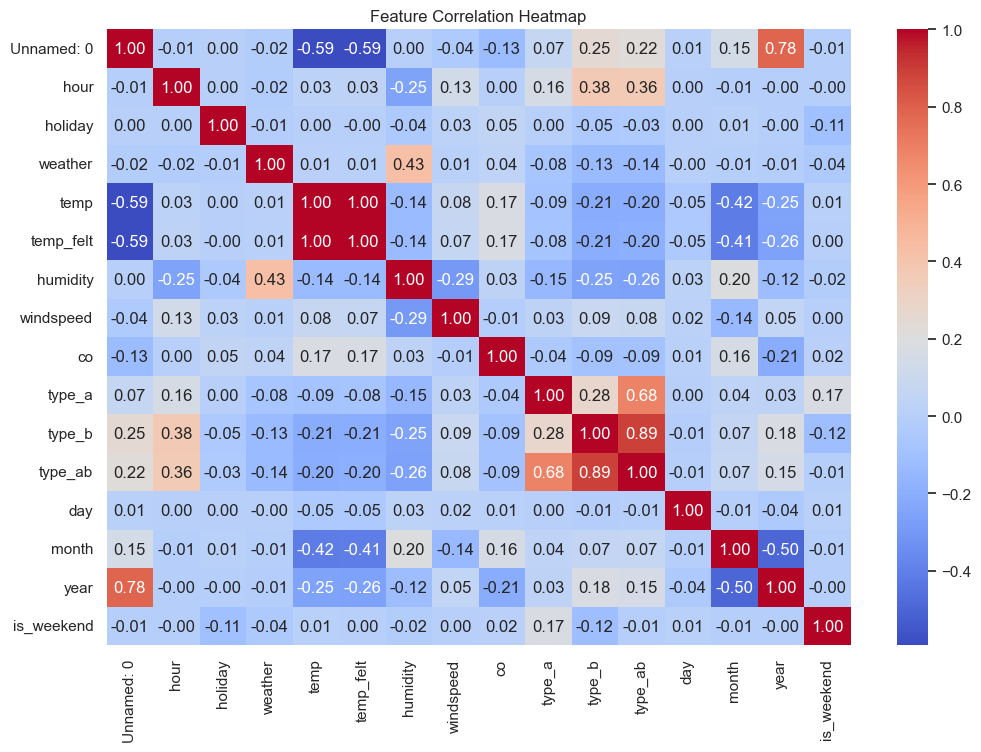

In [ ]:
numeric_data = train_data.select_dtypes(include=['number'])

correlation_matrix = numeric_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()

Notably, the correlation between temp and temp_felt feature is 1.0. One of them could be dropped as it would redundant information

In [ ]:
train_data = train_data.drop(columns=['temp_felt'])
val_data = val_data.drop(columns=['temp_felt'])
test_data = test_data.drop(columns=['temp_felt'])

Now, let's viusalize the distribution of all features and box plots to identify the anomalies

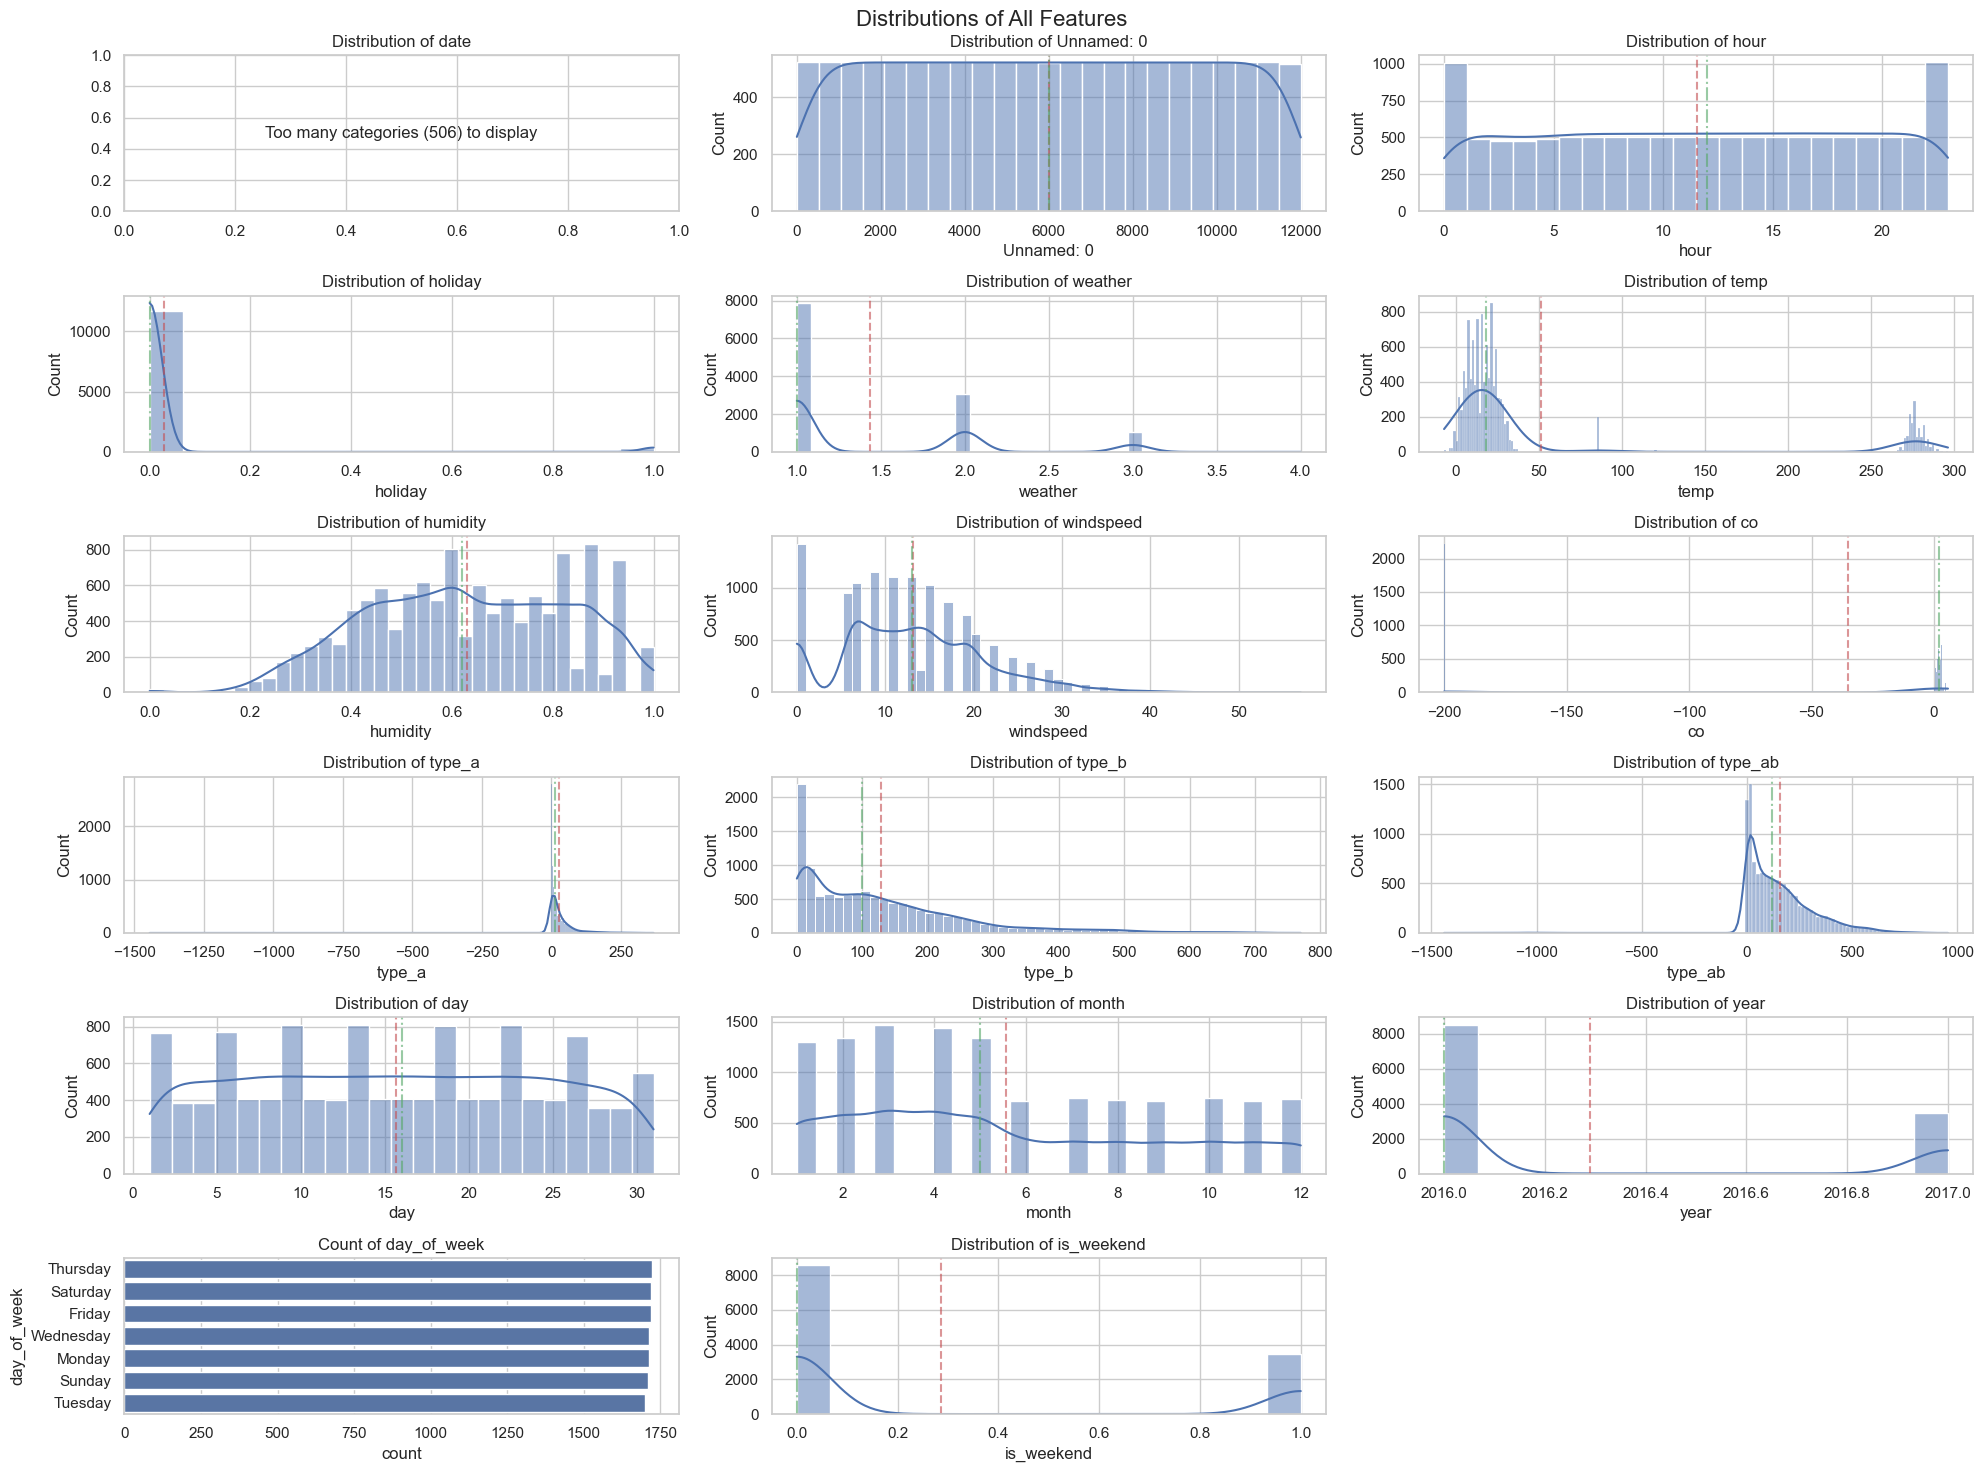

In [ ]:
plt.figure(figsize=(20, 15))
cols = train_data.columns

n_cols = 3
n_rows = (len(cols) + n_cols - 1) // n_cols

for i, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Checking if column is numeric, If so, plot histogram; otherwise, plot countplot
    if np.issubdtype(train_data[col].dtype, np.number):
        sns.histplot(train_data[col], kde=True)
        plt.title(f'Distribution of {col}')
        
        # Adding mean and median lines for the numeric data
        plt.axvline(train_data[col].mean(), color='r', linestyle='--', alpha=0.6, label='Mean')
        plt.axvline(train_data[col].median(), color='g', linestyle='-.', alpha=0.6, label='Median')
        if i == 0:
            plt.legend()
    else:
        # For categorical columns, use countplots
        if train_data[col].nunique() < 30:
            sns.countplot(y=train_data[col], order=train_data[col].value_counts().index)
            plt.title(f'Count of {col}')
        else:
            plt.text(0.5, 0.5, f'Too many categories ({train_data[col].nunique()}) to display', 
                     horizontalalignment='center', verticalalignment='center')
            plt.title(f'Distribution of {col}')
    
    plt.tight_layout()

plt.suptitle('Distributions of All Features', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

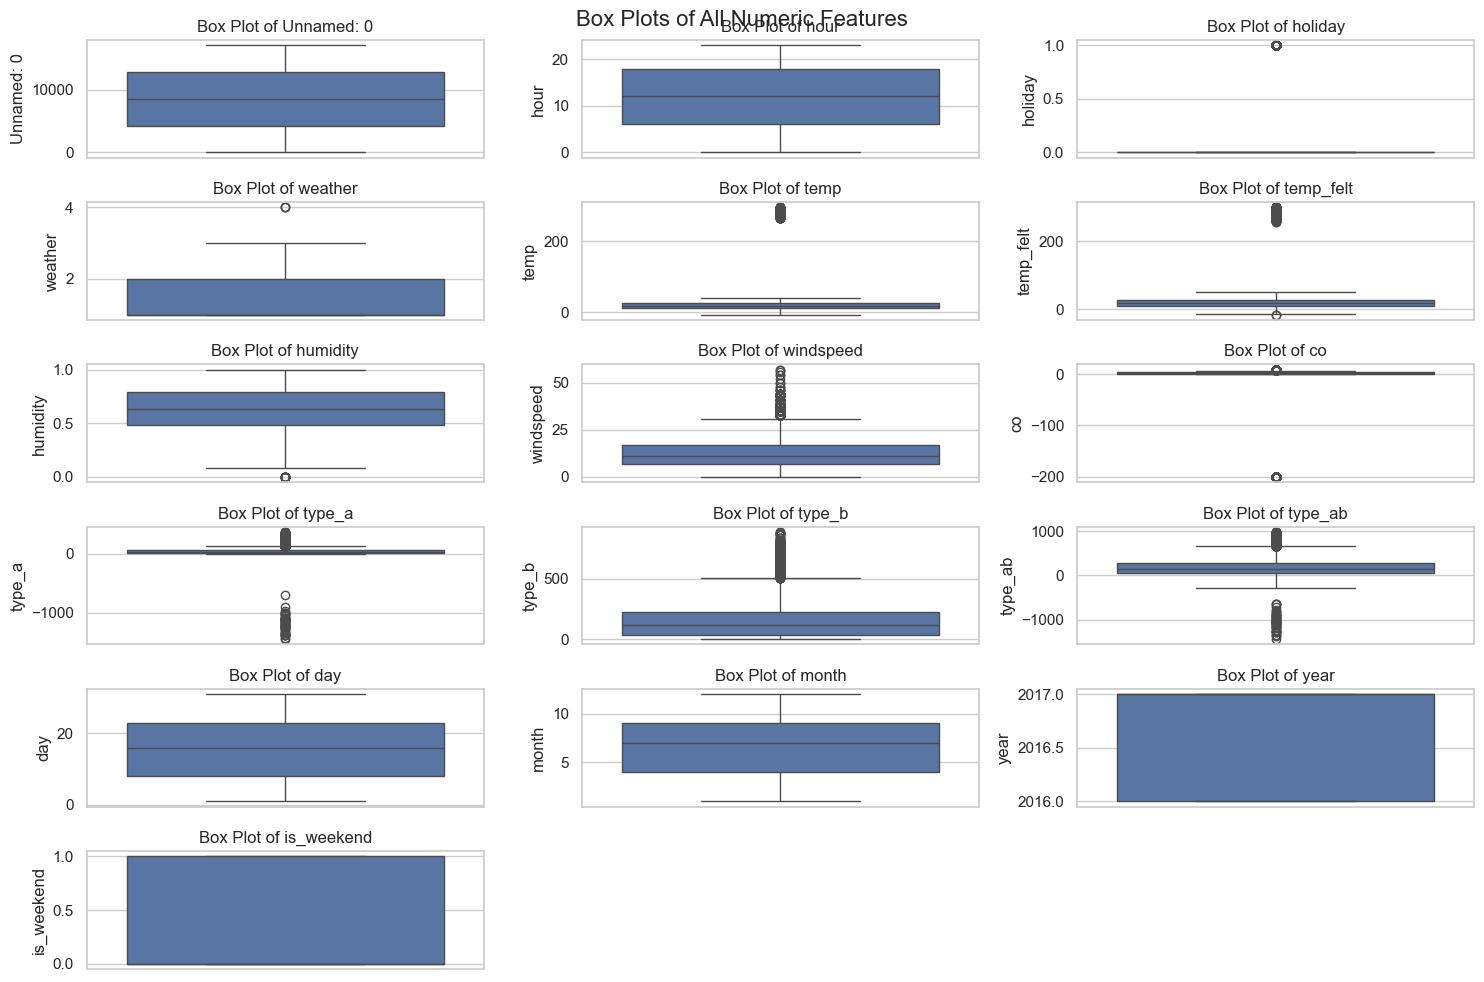

Potential Outliers Summary:

holiday: 500 potential outliers
  - Min outlier value: 1
  - Max outlier value: 1
  - Normal range: [0.00, 0.00]

weather: 3 potential outliers
  - Min outlier value: 4.0
  - Max outlier value: 4.0
  - Normal range: [-0.50, 3.50]

temp: 1571 potential outliers
  - Min outlier value: 266.09
  - Max outlier value: 296.17
  - Normal range: [-11.76, 48.40]

temp_felt: 1572 potential outliers
  - Min outlier value: -14.9968
  - Max outlier value: 298.14919999999995
  - Normal range: [-14.50, 53.50]

humidity: 22 potential outliers
  - Min outlier value: 0.0
  - Max outlier value: 0.0
  - Normal range: [0.01, 1.26]

windspeed: 318 potential outliers
  - Min outlier value: 32.9975
  - Max outlier value: 56.9969
  - Normal range: [-7.99, 31.99]

co: 3987 potential outliers
  - Min outlier value: -200.0
  - Max outlier value: 8.4
  - Normal range: [-2.80, 6.80]

type_a: 1056 potential outliers
  - Min outlier value: -1445.0
  - Max outlier value: 367.0
  - Normal ra

In [ ]:
# Creating box plots for all numeric columns to identify outliers
plt.figure(figsize=(15, 10))

numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
n_cols = len(numeric_cols)

plot_cols = 3
plot_rows = (n_cols + plot_cols - 1) // plot_cols

# Creating box plots
for i, col in enumerate(numeric_cols):
    plt.subplot(plot_rows, plot_cols, i+1)
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()

plt.suptitle('Box Plots of All Numeric Features', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

# Printing summary of potential outliers for each column
print("Potential Outliers Summary:")
for col in numeric_cols:
    # Calculate IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    
    if len(outliers) > 0:
        print(f"\n{col}: {len(outliers)} potential outliers")
        print(f"  - Min outlier value: {outliers.min()}")
        print(f"  - Max outlier value: {outliers.max()}")
        print(f"  - Normal range: [{lower_bound:.2f}, {upper_bound:.2f}]")

Many outliers in many features, let's handle them

In [27]:
# Replace 'weather' values greater than 3 with the mode of the column
train_data['weather'] = train_data['weather'].apply(lambda x: x if x <= 3 else train_data['weather'].mode()[0])
val_data['weather'] = val_data['weather'].apply(lambda x: x if x <= 3 else val_data['weather'].mode()[0])
test_data['weather'] = test_data['weather'].apply(lambda x: x if x <= 3 else test_data['weather'].mode()[0])

The highest temperature ever recorded in degrees was around 57. So any values above that would be considered as outlier

In [ ]:
def replace_temp_outliers(df, month_means_dict, default_mean):
    temp_outlier_mask = df['temp'] > 57
    
    if not temp_outlier_mask.any():
        return df
    
    df_copy = df.copy()
    
    # For each outlier row, look up the month's mean from training
    # If the month isn't found, use the default mean
    replacement_values = df_copy.loc[temp_outlier_mask, 'month'].map(
        lambda m: month_means_dict.get(m, default_mean)
    )
    
    # Apply the replacements only to the outlier rows
    df_copy.loc[temp_outlier_mask, 'temp'] = replacement_values
    
    return df_copy


# Calculate monthly temperature means from training data, excluding outliers
train_temp_monthly_means = train_data.loc[train_data['temp'] <= 57].groupby('month')['temp'].mean()

# Create a Series mapping months to their means
month_to_mean_mapping = train_temp_monthly_means.to_dict()

# For any month not in training, use overall valid mean from training
overall_valid_mean = train_data.loc[train_data['temp'] <= 57, 'temp'].mean()

# Apply the function to each dataset
train_data = replace_temp_outliers(train_data, month_to_mean_mapping, overall_valid_mean)
val_data = replace_temp_outliers(val_data, month_to_mean_mapping, overall_valid_mean)
test_data = replace_temp_outliers(test_data, month_to_mean_mapping, overall_valid_mean)

# Verify the results
for dataset_name, dataset in [("Training", train_data), ("Validation", val_data), ("Test", test_data)]:
    weather_outliers = (dataset['weather'] > 3.5).sum()
    temp_outliers = (dataset['temp'] > 57).sum()
    print(f"{dataset_name} set - Weather outliers: {weather_outliers}, Temperature outliers: {temp_outliers}")

Training set - Weather outliers: 0, Temperature outliers: 0
Validation set - Weather outliers: 0, Temperature outliers: 0
Test set - Weather outliers: 0, Temperature outliers: 0


The threesholds I got from box plots

In [ ]:
def replace_humidity_outliers(df, humidity_medians_dict, default_median):

    df_copy = df.copy()
    
    humidity_outlier_mask = df_copy['humidity'] < 0.03
    
    # If no outliers, return unchanged
    if not humidity_outlier_mask.any():
        return df_copy
    
    # For each outlier row, get its month and look up the corresponding median
    outlier_months = df_copy.loc[humidity_outlier_mask, 'month']
    replacement_values = outlier_months.map(
        lambda m: humidity_medians_dict.get(m, default_median)
    )
    
    # Apply the replacements only to the outlier rows
    df_copy.loc[humidity_outlier_mask, 'humidity'] = replacement_values
    
    return df_copy

train_humidity_monthly_medians = train_data.groupby('month')['humidity'].median()

train_humidity_medians_dict = train_humidity_monthly_medians.to_dict()

# Use overall median as fallback for months not in training
train_humidity_overall_median = train_data['humidity'].median()

# Apply the function to each dataset
train_data = replace_humidity_outliers(train_data, train_humidity_medians_dict, train_humidity_overall_median)
val_data = replace_humidity_outliers(val_data, train_humidity_medians_dict, train_humidity_overall_median)
test_data = replace_humidity_outliers(test_data, train_humidity_medians_dict, train_humidity_overall_median)

In [30]:
def replace_windspeed_outliers(df, windspeed_means_dict, default_mean):

    df_copy = df.copy()
    
    # Create mask for windspeed outliers
    windspeed_outlier_mask = (df_copy['windspeed'] < 0) | (df_copy['windspeed'] > 32)
    
    # If no outliers, return unchanged
    if not windspeed_outlier_mask.any():
        return df_copy
    
    # For each outlier row, get its month and look up the corresponding mean
    outlier_months = df_copy.loc[windspeed_outlier_mask, 'month']
    replacement_values = outlier_months.map(
        lambda m: windspeed_means_dict.get(m, default_mean)
    )
    
    # Apply the replacements only to the outlier rows
    df_copy.loc[windspeed_outlier_mask, 'windspeed'] = replacement_values
    
    return df_copy

# Calculate monthly valid windspeed means from the training data
train_windspeed_valid_means = train_data[
    (train_data['windspeed'] >= 0) & (train_data['windspeed'] <= 32)
].groupby('month')['windspeed'].mean()

train_windspeed_means_dict = train_windspeed_valid_means.to_dict()

# Use overall valid mean as fallback for months not in training
train_windspeed_overall_mean = train_data[
    (train_data['windspeed'] >= 0) & (train_data['windspeed'] <= 32)
]['windspeed'].mean()

# Apply the function to each dataset
train_data = replace_windspeed_outliers(train_data, train_windspeed_means_dict, train_windspeed_overall_mean)
val_data = replace_windspeed_outliers(val_data, train_windspeed_means_dict, train_windspeed_overall_mean)
test_data = replace_windspeed_outliers(test_data, train_windspeed_means_dict, train_windspeed_overall_mean)

In [31]:
def replace_co_outliers(df, co_means_dict, default_mean):

    df_copy = df.copy()
    
    # Create mask for CO outliers
    co_outlier_mask = (df_copy['co'] < 0.44) | (df_copy['co'] > 4.6)
    
    # If no outliers, return unchanged
    if not co_outlier_mask.any():
        return df_copy
    
    # For each outlier row, get its month and look up the corresponding mean
    outlier_months = df_copy.loc[co_outlier_mask, 'month']
    replacement_values = outlier_months.map(
        lambda m: co_means_dict.get(m, default_mean)
    )
    
    # Apply the replacements only to the outlier rows
    df_copy.loc[co_outlier_mask, 'co'] = replacement_values
    
    return df_copy

# Calculate monthly valid CO means from the training data only
train_co_valid_means = train_data[
    (train_data['co'] >= 0.44) & (train_data['co'] <= 4.6)
].groupby('month')['co'].mean()

train_co_means_dict = train_co_valid_means.to_dict()

# Use overall valid mean as fallback for months not in training
train_co_overall_mean = train_data[
    (train_data['co'] >= 0.44) & (train_data['co'] <= 4.6)
]['co'].mean()

# Apply the function to each dataset
train_data = replace_co_outliers(train_data, train_co_means_dict, train_co_overall_mean)
val_data = replace_co_outliers(val_data, train_co_means_dict, train_co_overall_mean)
test_data = replace_co_outliers(test_data, train_co_means_dict, train_co_overall_mean)

# Check for any remaining outliers
for dataset_name, dataset in [("Training", train_data), ("Validation", val_data), ("Test", test_data)]:
    co_outliers = ((dataset['co'] < 0.44) | (dataset['co'] > 4.6)).sum()
    print(f"{dataset_name} set - CO outliers remaining: {co_outliers}")

Training set - CO outliers remaining: 0
Validation set - CO outliers remaining: 0
Test set - CO outliers remaining: 0


type_a and type_b had also outliers, let's handle them on the training data as they have already been dropped in the validation and test sets

In [32]:
def replace_negative_values_with_interpolation(df, column_name):

    df_copy = df.copy()
    
    # Combine 'date' and 'hour' columns into a datetime
    if 'datetime' not in df_copy.columns:
        df_copy['datetime'] = pd.to_datetime(df_copy['date']) + pd.to_timedelta(df_copy['hour'], unit='h')
    
    # Set 'datetime' as the DataFrame index
    df_copy = df_copy.set_index('datetime')
    
    # Replace negative values using time interpolation
    df_copy[column_name] = df_copy[column_name].mask((df_copy[column_name] < 0)).interpolate(method='time')
    
    # Reset the index to get datetime column back
    df_copy = df_copy.reset_index()

    return df_copy

# Clean type_a column
train_data = replace_negative_values_with_interpolation(train_data, 'type_a')

# Clean type_b column 
train_data = replace_negative_values_with_interpolation(train_data, 'type_b')

# Verify the changes
print(f"Negative values in type_a: {(train_data['type_a'] < 0).sum()}")
print(f"Negative values in type_b: {(train_data['type_b'] < 0).sum()}")

Negative values in type_a: 0
Negative values in type_b: 0


In [33]:
# Ensure type_ab is recalculated after cleaning
train_data['type_ab'] = train_data['type_a'] + train_data['type_b']

In [34]:
# Exclude samples that have negative values in the target variable from the validation and test sets
val_data = val_data[val_data['type_ab'] >= 0]
test_data = test_data[test_data['type_ab'] >= 0]

# Exploratory Data Analysis

## Temporal patterns visualization

C:\Users\PC\AppData\Local\Temp\ipykernel_39824\3755467120.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_usage = train_data.set_index('date').resample('M')['type_ab'].mean()


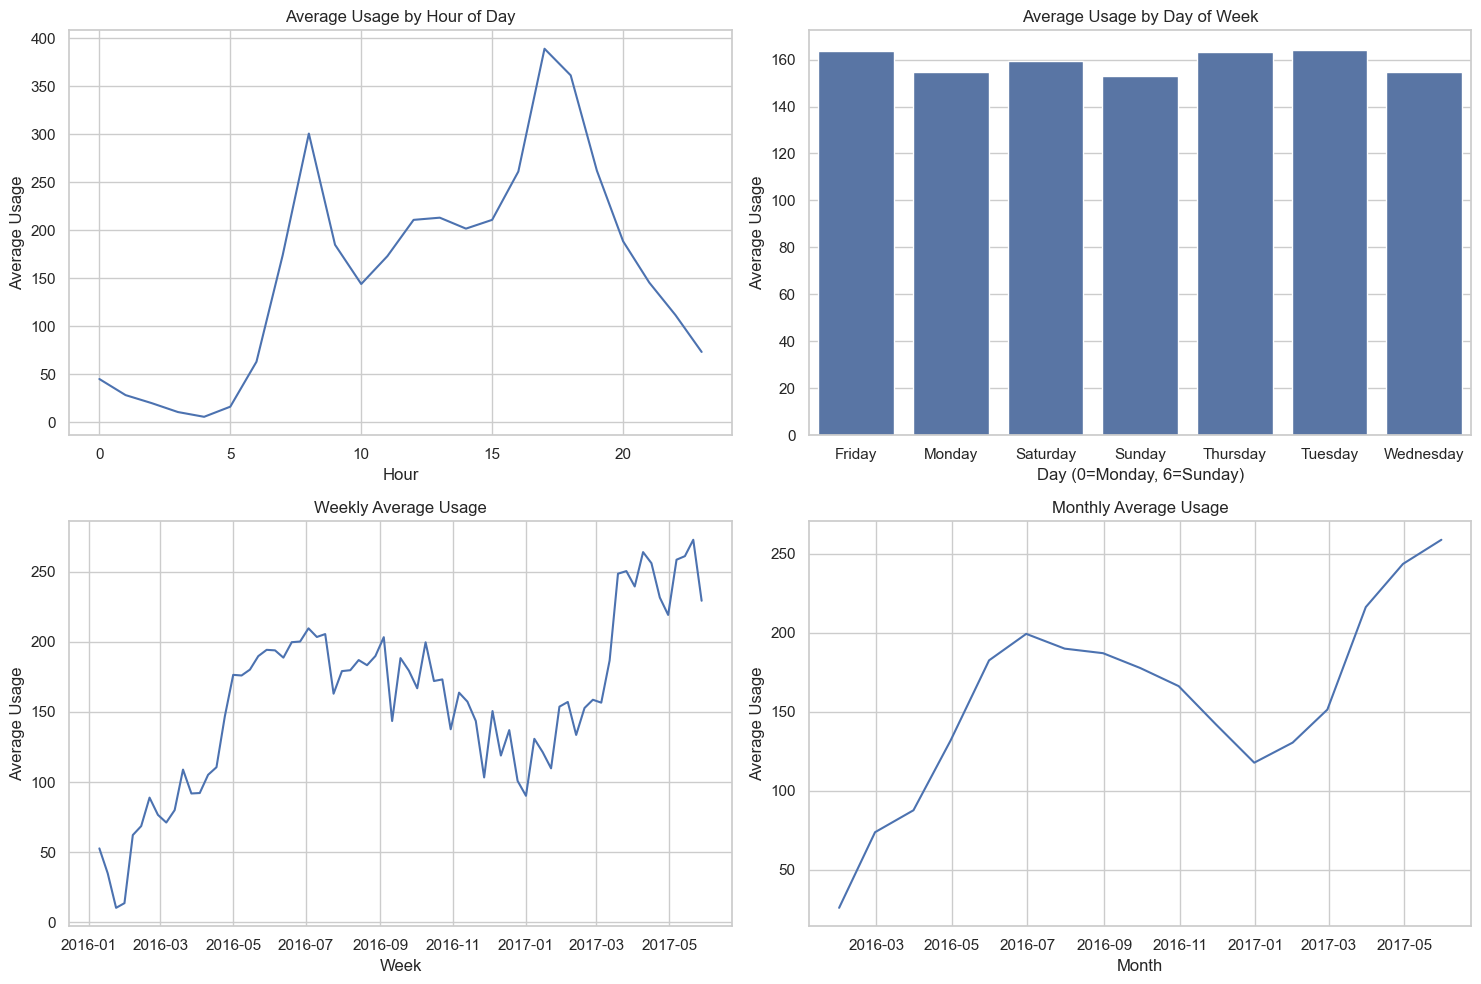

In [35]:
plt.figure(figsize=(15, 10))

# Usage by hour of day
plt.subplot(2, 2, 1)
hourly_avg = train_data.groupby('hour')['type_ab'].mean()
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
plt.title('Average Usage by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Usage')

# Usage by day of week
plt.subplot(2, 2, 2)
dow_avg = train_data.groupby('day_of_week')['type_ab'].mean()
sns.barplot(x=dow_avg.index, y=dow_avg.values)
plt.title('Average Usage by Day of Week')
plt.xlabel('Day (0=Monday, 6=Sunday)')
plt.ylabel('Average Usage')

# Weekly patterns
plt.subplot(2, 2, 3)
weekly_usage = train_data.set_index('date').resample('W')['type_ab'].mean()
sns.lineplot(x=weekly_usage.index, y=weekly_usage.values)
plt.title('Weekly Average Usage')
plt.xlabel('Week')
plt.ylabel('Average Usage')

# Monthly patterns
plt.subplot(2, 2, 4)
monthly_usage = train_data.set_index('date').resample('M')['type_ab'].mean()
sns.lineplot(x=monthly_usage.index, y=monthly_usage.values)
plt.title('Monthly Average Usage')
plt.xlabel('Month')
plt.ylabel('Average Usage')

plt.tight_layout()
plt.show()

Some remarks :
- There is a positive trend in the usage, this means that the number of rents increases by time
- The peak usage time is between 15 and 20 O'clock
- Sunday is the day with minimum rentals

## Compare usage patterns between user groups

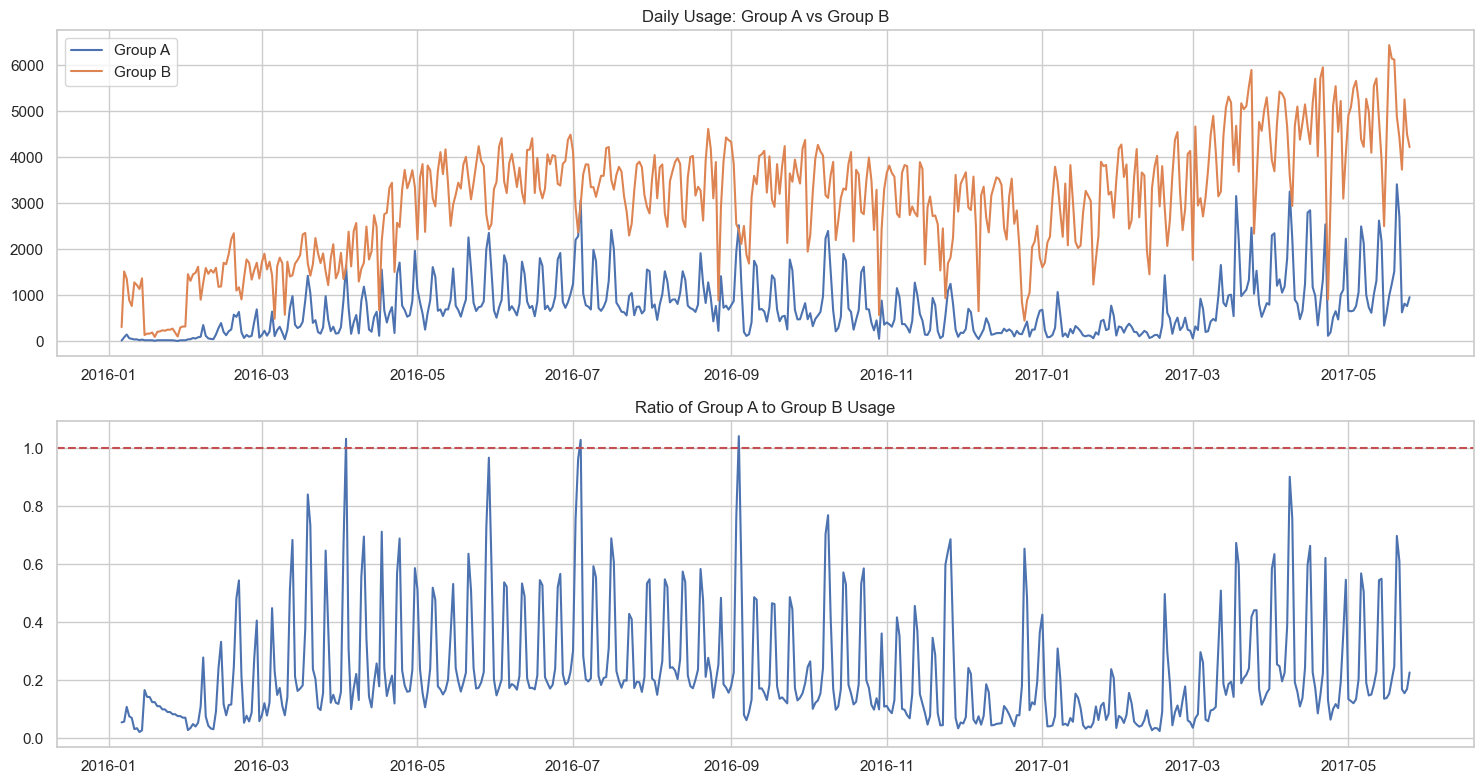

In [36]:
# Compare usage patterns between user groups
plt.figure(figsize=(15, 8))

# Time series comparison
plt.subplot(2, 1, 1)
df_grouped = train_data.groupby(pd.Grouper(key='date', freq='D')).agg({
    'type_a': 'sum',
    'type_b': 'sum'
}).reset_index()
plt.plot(df_grouped['date'], df_grouped['type_a'], label='Group A')
plt.plot(df_grouped['date'], df_grouped['type_b'], label='Group B')
plt.title('Daily Usage: Group A vs Group B')
plt.legend()

# Usage ratio
plt.subplot(2, 1, 2)
df_grouped['ratio_A_to_B'] = df_grouped['type_a'] / df_grouped['type_b']
plt.plot(df_grouped['date'], df_grouped['ratio_A_to_B'])
plt.title('Ratio of Group A to Group B Usage')
plt.axhline(y=1, color='r', linestyle='--')

plt.tight_layout()
plt.show()

We can clearly see that the usage of group b is higher than a

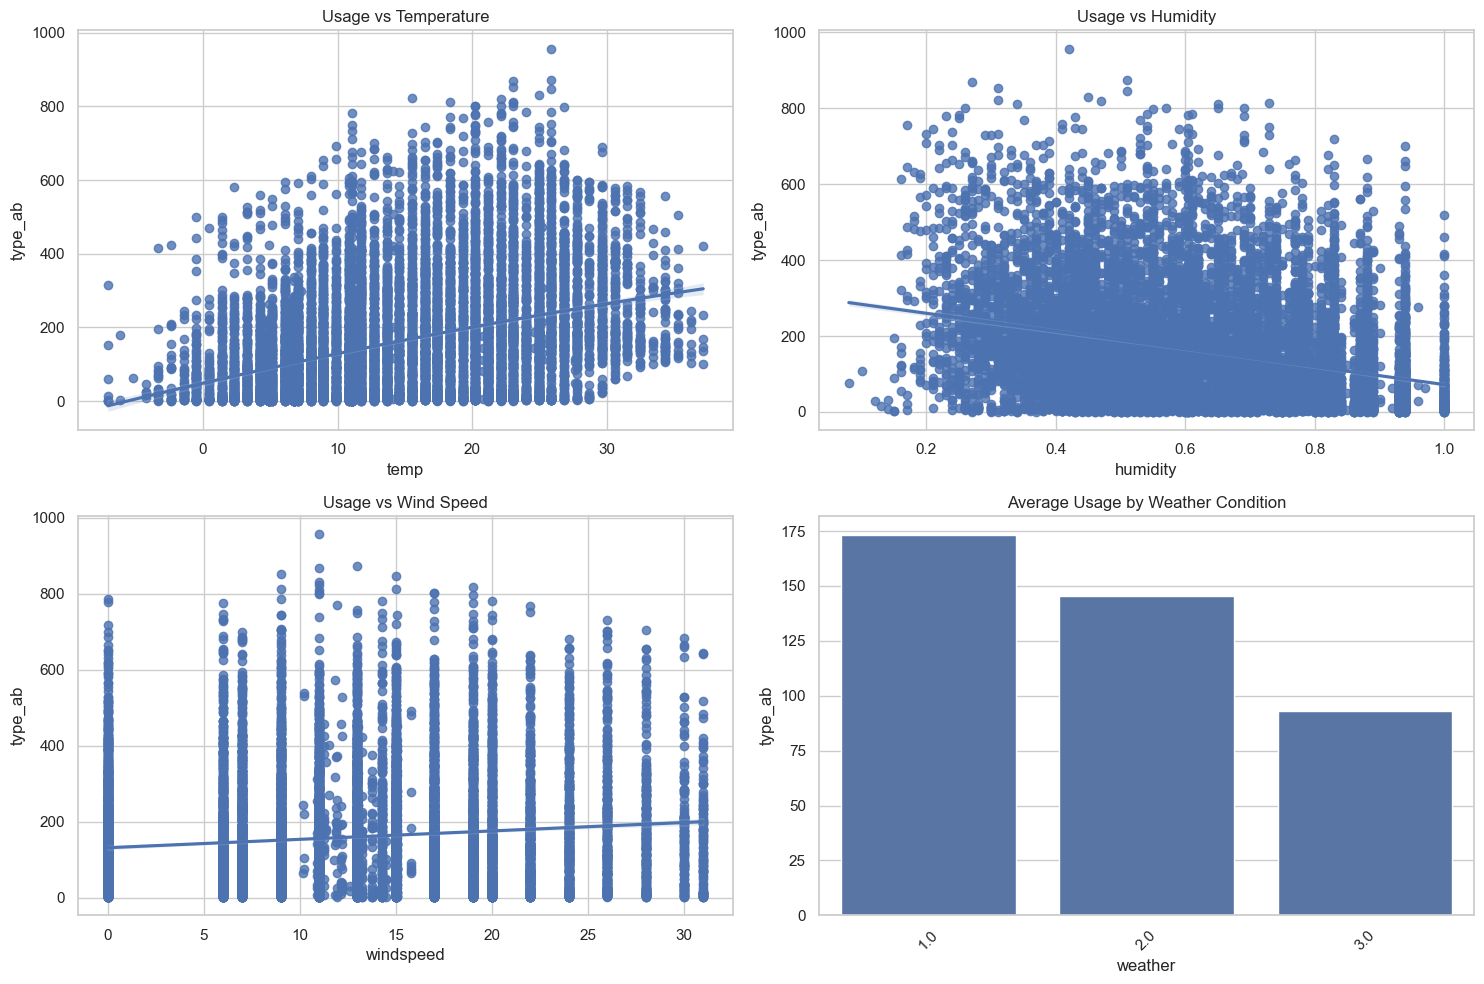

In [37]:
# Weather impact visualizations
plt.figure(figsize=(15, 10))

# Usage vs temperature with polynomial fit
plt.subplot(2, 2, 1)
sns.regplot(x='temp', y='type_ab', data=train_data, order=2)
plt.title('Usage vs Temperature')

# Usage vs humidity
plt.subplot(2, 2, 2)
sns.regplot(x='humidity', y='type_ab', data=train_data)
plt.title('Usage vs Humidity')

# Usage vs wind speed
plt.subplot(2, 2, 3)
sns.regplot(x='windspeed', y='type_ab', data=train_data)
plt.title('Usage vs Wind Speed')

# Usage vs weather conditions
if 'weather' in train_data.columns:
    plt.subplot(2, 2, 4)
    weather_usage = train_data.groupby('weather')['type_ab'].mean().reset_index()
    sns.barplot(x='weather', y='type_ab', data=weather_usage)
    plt.title('Average Usage by Weather Condition')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Some remarks :
- There is a positive trend of the usage with the weather. The maximum rentals were between 20 and 50 degrees.
- There is a negative trend of the usage with the humudity. The maximum rentals were between 0.4 and 0.6.
- There is a small positive trend of the usage with the windspeed. The maximum rentals were between 10 and 15 degrees.
- The maimum rentals were at weather condition 1.

## Monthly average rentals

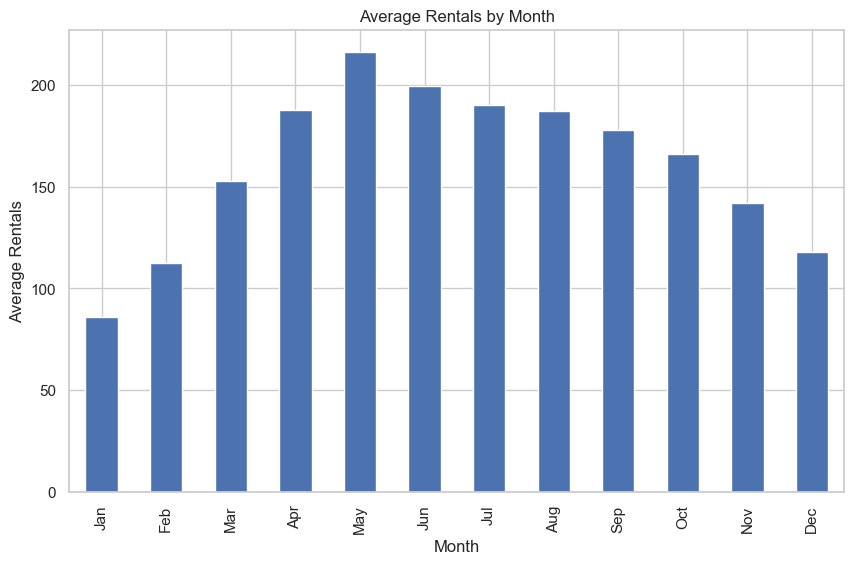

In [38]:
monthly_rentals = train_data.groupby(train_data['datetime'].dt.month)['type_ab'].mean()
plt.figure(figsize=(10, 6))
monthly_rentals.plot(kind='bar')
plt.title('Average Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Average Rentals')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

The maximum usage of scooters was between months April and September. This makes sense as the weather in these months is comfortable while the minimum usage was in the winter months December, January and February

## Calculate correlations with the target variable and visualize them


Correlations with target variable (type_ab):
type_ab       1.000000
hour          0.392715
temp          0.383583
Unnamed: 0    0.239626
year          0.163536
windspeed     0.107312
month         0.075914
day          -0.010847
is_weekend   -0.011445
holiday      -0.033028
co           -0.101807
weather      -0.151983
humidity     -0.300413
Name: type_ab, dtype: float64


C:\Users\PC\AppData\Local\Temp\ipykernel_39824\1881272842.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Correlation', y='Feature', data=corr_df, palette=colors)


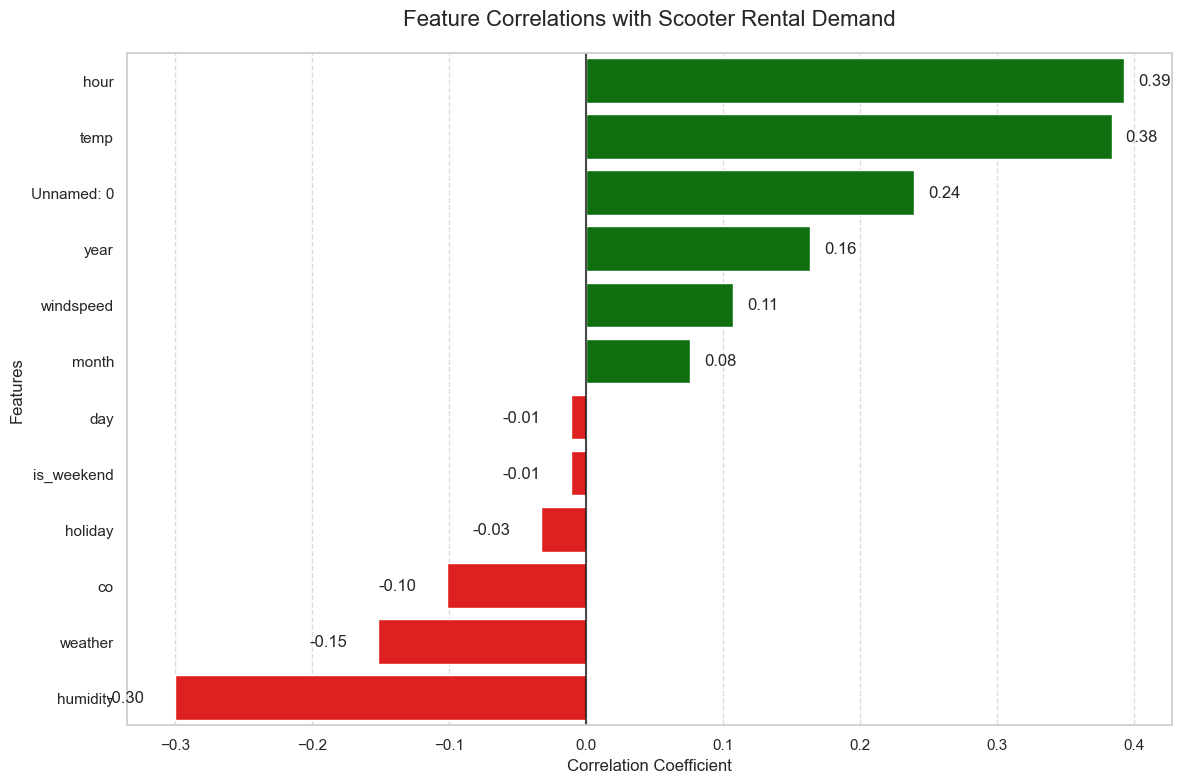

In [39]:
# Get numeric columns and calculate correlations
numeric_data = train_data.select_dtypes(include=['number']) 

# Exclude type_a and type_b from the correlation matrix
numeric_data = numeric_data.drop(columns=['type_a', 'type_b'])

# Calculate correlations with the target variable
corr_with_target = numeric_data.corr()['type_ab'].sort_values(ascending=False)
print("Correlations with target variable (type_ab):")
print(corr_with_target)

# Create a DataFrame for plotting
corr_df = pd.DataFrame(corr_with_target)
corr_df.columns = ['Correlation']
corr_df = corr_df.reset_index()
corr_df.columns = ['Feature', 'Correlation']

# Filter out the target variable itself from the plot
corr_df = corr_df[corr_df['Feature'] != 'type_ab']

# Create the figure
plt.figure(figsize=(12, 8))

# Create a color palette based on correlation values
colors = ['red' if x < 0 else 'green' for x in corr_df['Correlation']]

# Plot the bar chart with color-coded bars
bars = sns.barplot(x='Correlation', y='Feature', data=corr_df, palette=colors)

# Add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)

# Add value labels to the bars
for i, v in enumerate(corr_df['Correlation']):
    plt.text(v + 0.01 if v >= 0 else v - 0.05, i, f'{v:.2f}', va='center')

plt.title('Feature Correlations with Scooter Rental Demand', fontsize=16, pad=20)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

The features hour and temp had the strongest positive correlation with rentals while the humidity had the strongest negative correlation

# Data Preperation for Modelling

type_a and type_b columns are now not important so they can be dropped from the training data to avoid data lekeage

In [40]:
train_data = train_data.drop(columns=['type_a', 'type_b'])

In [41]:
# Define the features and target variable for the sets
x_train = train_data.drop(columns=['type_ab'])
y_train = train_data['type_ab']
x_val = val_data.drop(columns=['type_ab'])
y_val = val_data['type_ab']
x_test = test_data.drop(columns=['type_ab'])
y_test = test_data['type_ab']


In [42]:
# Reset indices
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [43]:
# Identify and remove datetime columns
datetime_cols = x_train.select_dtypes(include=['datetime64']).columns.tolist()
X_train_cleaned = x_train.drop(columns=datetime_cols)
datetime_cols = x_val.select_dtypes(include=['datetime64']).columns.tolist()
X_val_cleaned = x_val.drop(columns=datetime_cols)
datetime_cols = x_test.select_dtypes(include=['datetime64']).columns.tolist()
X_test_cleaned = x_test.drop(columns=datetime_cols)

In [44]:
# Identify any string/categorical columns in the cleaned data
object_cols = x_train.select_dtypes(include=['object', 'category']).columns.tolist()

for col in object_cols:
    # Convert to category codes
    X_train_cleaned[col] = pd.Categorical(X_train_cleaned[col]).codes
    X_val_cleaned[col] = pd.Categorical(X_val_cleaned[col]).codes
    X_test_cleaned[col] = pd.Categorical(X_test_cleaned[col]).codes

In [45]:
# Scaling features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_val_scaled = scaler.transform(X_val_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

## 5. Model Building
Let's implement and evaluate multiple regression models for predicting scooter rentals.


--- Training Random Forest ---
Training RMSE: 13.3372
Validation RMSE: 75.6491
Validation R²: 0.8833
Training time: 6.69 seconds

--- Training SVM ---
Training RMSE: 107.5705
Validation RMSE: 189.9296
Validation R²: 0.2641
Training time: 25.38 seconds

--- Training XGBoost ---
Training RMSE: 36.5267
Validation RMSE: 74.5920
Validation R²: 0.8865
Training time: 0.33 seconds

--- Model Comparison ---
Best model: XGBoost with validation RMSE: 74.5920


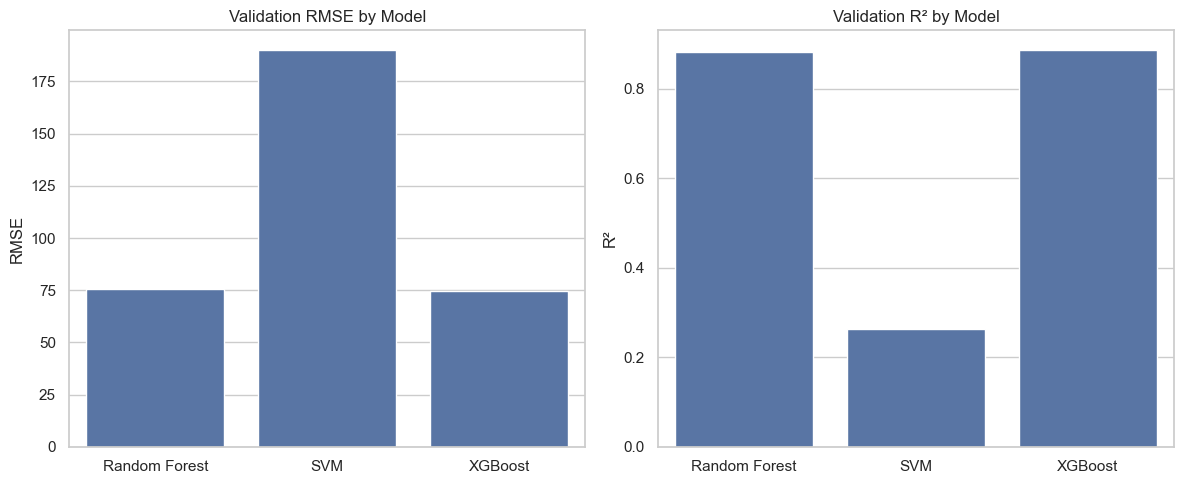


--- XGBoost Performance on Test Set ---
Test RMSE: 83.5521
Test MAE: 55.3980
Test R²: 0.8545


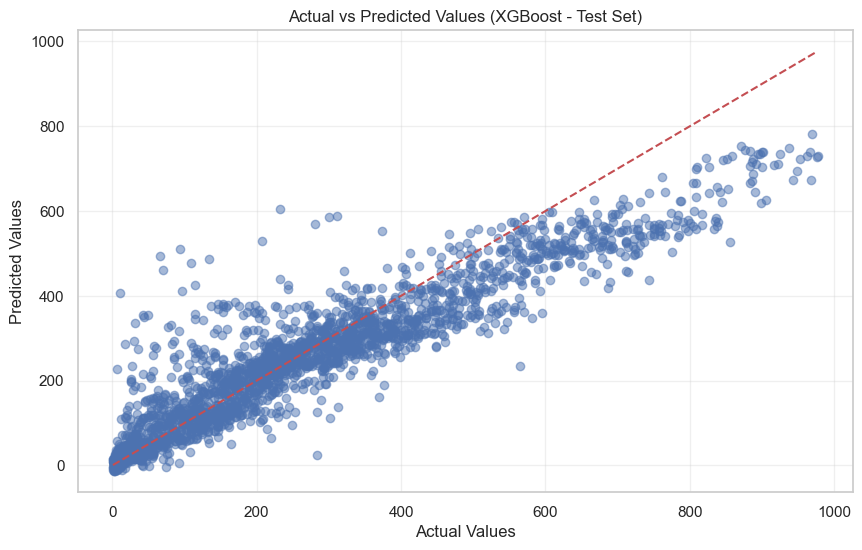

Best model saved as 'best_model_xgboost.joblib'


In [ ]:
results = {}

# 1. Train Random Forest model
print("\n--- Training Random Forest ---")
start_time = time()

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_cleaned, y_train)

# Get predictions
rf_train_preds = rf.predict(X_train_cleaned)
rf_val_preds = rf.predict(X_val_cleaned)

# Evaluate
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_preds))
rf_val_rmse = np.sqrt(mean_squared_error(y_val, rf_val_preds))
rf_val_r2 = r2_score(y_val, rf_val_preds)

print(f"Training RMSE: {rf_train_rmse:.4f}")
print(f"Validation RMSE: {rf_val_rmse:.4f}")
print(f"Validation R²: {rf_val_r2:.4f}")
print(f"Training time: {time() - start_time:.2f} seconds")

results['Random Forest'] = {
    'model': rf,
    'train_rmse': rf_train_rmse,
    'val_rmse': rf_val_rmse,
    'val_r2': rf_val_r2
}

# 2. Train SVM model
print("\n--- Training SVM ---")
start_time = time()
svm = SVR(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train_scaled, y_train)

# Get predictions
svm_train_preds = svm.predict(X_train_scaled)
svm_val_preds = svm.predict(X_val_scaled)

# Evaluate
svm_train_rmse = np.sqrt(mean_squared_error(y_train, svm_train_preds))
svm_val_rmse = np.sqrt(mean_squared_error(y_val, svm_val_preds))
svm_val_r2 = r2_score(y_val, svm_val_preds)

print(f"Training RMSE: {svm_train_rmse:.4f}")
print(f"Validation RMSE: {svm_val_rmse:.4f}")
print(f"Validation R²: {svm_val_r2:.4f}")
print(f"Training time: {time() - start_time:.2f} seconds")

results['SVM'] = {
    'model': svm,
    'train_rmse': svm_train_rmse,
    'val_rmse': svm_val_rmse,
    'val_r2': svm_val_r2
}

# 3. Train XGBoost model
print("\n--- Training XGBoost ---")
start_time = time()

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
xgb_model.fit(X_train_cleaned, y_train)

# Get predictions
xgb_train_preds = xgb_model.predict(X_train_cleaned)
xgb_val_preds = xgb_model.predict(X_val_cleaned)

# Evaluate
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_preds))
xgb_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
xgb_val_r2 = r2_score(y_val, xgb_val_preds)

print(f"Training RMSE: {xgb_train_rmse:.4f}")
print(f"Validation RMSE: {xgb_val_rmse:.4f}")
print(f"Validation R²: {xgb_val_r2:.4f}")
print(f"Training time: {time() - start_time:.2f} seconds")

results['XGBoost'] = {
    'model': xgb_model,
    'train_rmse': xgb_train_rmse,
    'val_rmse': xgb_val_rmse,
    'val_r2': xgb_val_r2
}

# Model Comparison
print("\n--- Model Comparison ---")
model_names = list(results.keys())
val_rmse = [results[model]['val_rmse'] for model in model_names]
val_r2 = [results[model]['val_r2'] for model in model_names]

# Find the best model
best_model_name = model_names[np.argmin(val_rmse)]
print(f"Best model: {best_model_name} with validation RMSE: {min(val_rmse):.4f}")

# Visualize model comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=model_names, y=val_rmse)
plt.title('Validation RMSE by Model')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
sns.barplot(x=model_names, y=val_r2)
plt.title('Validation R² by Model')
plt.ylabel('R²')

plt.tight_layout()
plt.show()

# Evaluate best model on test set
best_model = results[best_model_name]['model']

if best_model_name == 'SVM':
    test_preds = best_model.predict(X_test_scaled)
else:
    test_preds = best_model.predict(X_test_cleaned)

test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"\n--- {best_model_name} Performance on Test Set ---")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Visualize actual vs predicted values for best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values ({best_model_name} - Test Set)')
plt.grid(True, alpha=0.3)
plt.show()

# Save the best model
joblib.dump(best_model, f'best_model_{best_model_name.lower().replace(" ", "_")}.joblib')
print(f"Best model saved as 'best_model_{best_model_name.lower().replace(' ', '_')}.joblib'")